## Calculation of chemotaxis params 

*written by Medea Zanoli*

For each experiment repetition, generate the following plots: 

* the linear distribution of cell accummulation inside the pipettes + ratio between capillar with chemoattract and capillar without (chemotacitc index inside)
* the radial distribution of cell accummulation outside the pipettes + ratio between capillar with chemoattract and capillar without (chemotacitc index outside) 
* velocity distribution in different location of space: inside the two capillars, near the capillar entrances, away from the chemoattractant capillar 

In [1]:
from PIL import Image, ImageEnhance, ImageSequence, ImageOps,  ImageChops, ImageFilter,  ImageDraw
from tkinter import Tk
from tkinter.filedialog import askdirectory, askopenfilename
import os
import glob
import matplotlib.pyplot as plt
from matplotlib import path
import matplotlib
import matplotlib.colors as colors
%matplotlib inline 
import numpy as np
from progressbar import ProgressBar
import progressbar
import pandas as pd
import cv2 
import seaborn as sns
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import math
import pims
import trackpy as tp 
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
from moviepy.editor import VideoFileClip, clips_array, vfx
import pickle
from scipy import interpolate
#Choosing histograms bins: try different binning methods
import astropy
from astropy import stats
from os import walk
import json
import scipy 
from scipy.interpolate import UnivariateSpline
from matplotlib.offsetbox import AnchoredText
import plotly.graph_objects as go
import warnings
from scipy.stats import pearsonr
from scipy import optimize

#suppress warnings
warnings.filterwarnings('ignore')

#‘blocks’ : use bayesian blocks for dynamic bin widths -> too much computing requirements 
#‘knuth’ : use Knuth’s rule to determine bins
#‘scott’ : use Scott’s rule to determine bins
#‘freedman’ : use the Freedman-Diaconis rule to determine bins
sns.set()
sns.set_theme('poster') # paper, notebook, talk, poster
sns.set_style('ticks')

# define the function to do the linear fit
def linear_fit(x, a, b):
    y = a - b*x 
    return y

# conversion factor from pixel to um 
px_um_conversion_factor = 2.703

# image size: it should be the same for all videos!
image_height, image_width = 720, 1280

#### Decide some characteristics of the analyis: 
            
* decide the size (in frames) of the rolling window to apply to the data to get the max value of R: 
            e.g.    window_size = 1800  

* You can apply a filter to try to remove the cells which get stuck at the entrance of the capillar (both outside and inside). To decide whether a cell is stuck, you must give a maximum radius in which the cell should stay for a minimum amount of time. Set **remove_stuck_cells = False** if you don't want to filter out any cell. 
            e.g. remove_stuck_cells = True
                 n_frames = 30*10  --> the cell must remain stuck minimum 10 seconds to be removed
                 radius = 30  --> max distance (in pixels) between different points in the trajectory to consider it stuck 



* give the directory where the dataframes are stored: this folder should contain: df_up, df_low and pipette_propeties for all files. Files must be saved as: *df_up_ + repetition name, df_up_ + repetition name, pipette_propeties + repetition name*

            e.g.   input_path  = ...

* give the directory where the figures will be saved 
            e.g.   output_path  = ...



In [2]:
from ipynb.fs.full.my_functions import order_list, read_pipette_dictionary_txt, read_pipette_dictionary_json, spline_interpolation,  speed_distribution
from ipynb.fs.full.my_functions import  filter_cells_radius, angles_distribution, find_common_part_of_name,  exp_fit_outside, is_it_increasing, exp_fit_entrance_pipette, velocity_matrix, speed_distribution

In [3]:
# do we want to remove the stuck cells? if yes, set to True
remove_stuck_cells = False

In [4]:
# jason or txt pipette file?
pipette_dictionary  = True
json_pipette = False

In [5]:
# decide size of the rolling window to apply to find the moment of maximum signal
window_size = 1800# 1800 = 1 minute (30 frames/sec)

In [6]:
# folder where you have the dataframes
input_path = askdirectory()

In [7]:
# folder where you save the figure 
output_path = askdirectory()

### Until chemotactic indexes

---#---------------------------------------------------------------------------------------------------
PROCESSING G_D200_R2
------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------
INSIDE THE PIPETTES
------------------------------------------------------------------------------------------------------
fit all the distribution inside
first fit lambda: 94.3
(0.4786564921556765, 5.399443640196949e-06)
second fit on: 17 points
second fit lambda: 96.7
(0.9834768380471208, 1.5116028593878616e-12)
second fit on: 17 points
third fit lambda: 150.4
(0.9709594339909764, 5.990288612339768e-05)
index to start fit outsie 1
1st fit outside: lambda = 32.8 , p = 0.94427 
length fit: 3
(1411918, 19)
------------------------------------------------------------------------------------------------------
SPEED DISTRIBUTION
------------------------------------

end speed distribution
finihed speed distribution on entire video
running a rolling window over the pipettes: calculating cell distribution inside and outside...


100% |########################################################################|


doing spline interpolation inside the pipette ...
s_up is: 100.0000000 
s_low is: 1.0000000 
doing spline interpolation outside the pipette ...
s_up is: 10.0000000 
s_low is: 1.0000000 


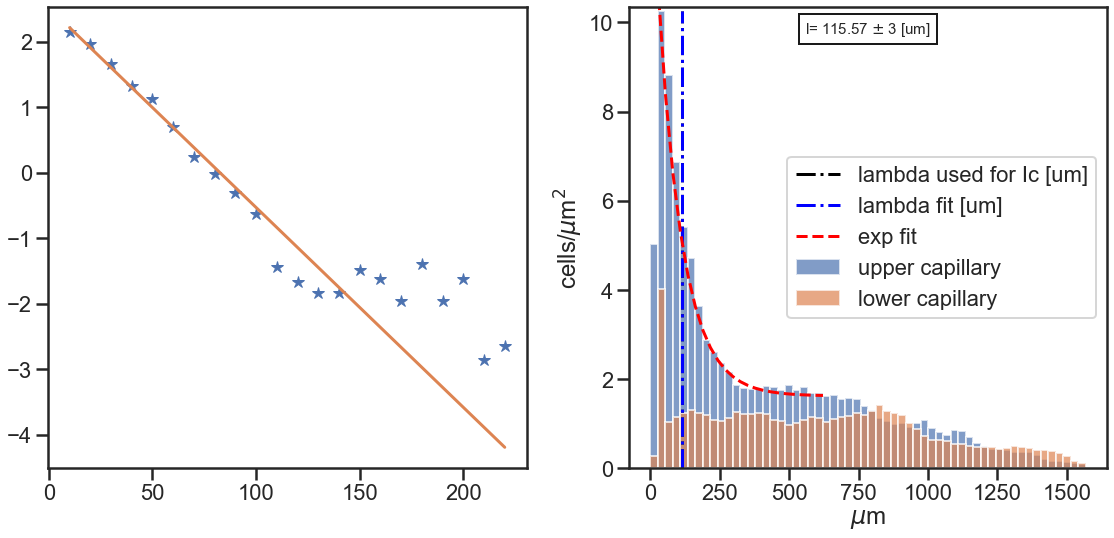

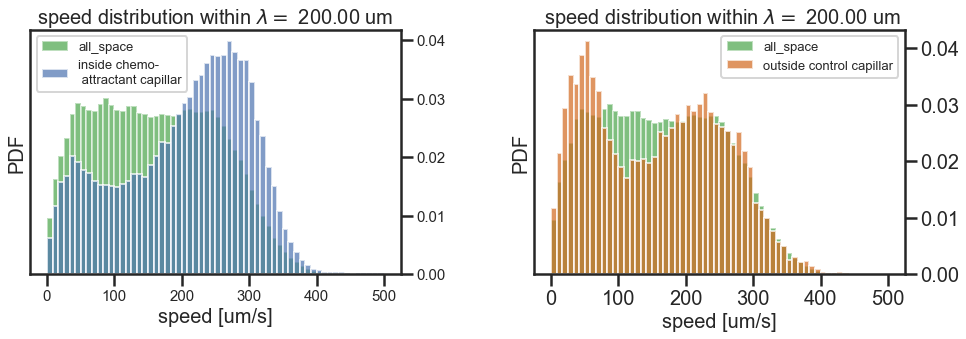

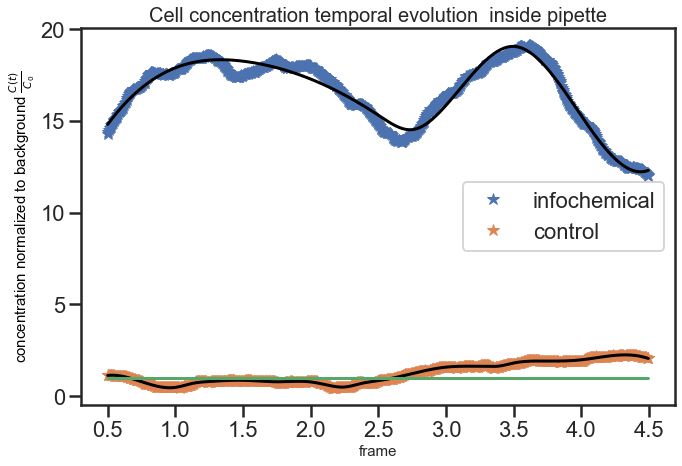

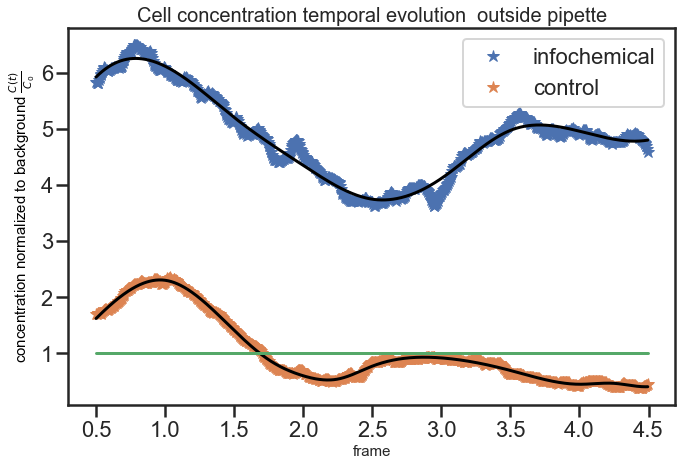

In [8]:
# get all the file names in a directory: this should put in a list all the names of the 
# various df_up, df_low and pipette_properties files 
f = []

for (dirpath, dirnames, filenames) in walk(input_path):
    f.extend(filenames)
    break

# now I select only the files starting with "df_up", so that I can strip from the file name the string "df_up_" and ".txt"
# to get the name of each repetition (e.g. 'G_D200_R1','G_D200_R2','G_D200_R3',...)

names_list = []
for filename in f: 
    if(filename.startswith('df_up')):
        filename = filename.replace('df_up_', '')
        names_list.append(filename)
        
# check if the videos name were correctly rea
if( len(names_list) == 0 ): 
    print( 'VIDEO FILE NAMES NOT IMPORTED CORRECTLY' )
    
names_list = ['G_D200_R2']

#find the common part of the name: example G_D20
common_part_of_name = find_common_part_of_name(names_list)

for video_name in names_list[0:]: 
    
    print('---#---------------------------------------------------------------------------------------------------')
    print('PROCESSING %s' %video_name )
    print('------------------------------------------------------------------------------------------------------')

    
    ### import pipette properties (needed to know where the center of the pipette is)
    # select the pipette properties file to use 
    if(pipette_dictionary):
        pipette_properties_dictionary  = read_pipette_dictionary_txt(input_path, video_name)

    
    # WHIT JSON FILE
    # with json
    if(json_pipette):
        pipette_properties_dictionary  = read_pipette_dictionary_json(input_path, video_name)

    # import df_up and df_low
    with open(input_path+"/df_up_"+video_name + ".txt", "rb") as myFile:
        df_up = pickle.load(myFile)   

    with open(input_path+"/df_low_"+video_name + ".txt", "rb") as myFile:
        df_low = pickle.load(myFile)   

    # create a column "frame"    
    df_up.reset_index(level=0, inplace=True)
    df_low.reset_index(level=0, inplace=True)

    if(len(np.unique(df_up.frame)) <= window_size):
        raise Exception("ERROR: the dataframe is smaller than the window size ")
    

    # GET ALL THE COORDINATES OF THE PIPETTE (CENTER, THETA, ETC..)
    # read the x-y coordinates of the pipette center
    x_center_pipette_up, y_center_pipette_up= pipette_properties_dictionary['x_center_upper_pipette'],  pipette_properties_dictionary['y_center_upper_pipette']# IN PIXEL!!!!!
    x_center_pipette_low, y_center_pipette_low  = pipette_properties_dictionary['x_center_lower_pipette'], pipette_properties_dictionary['y_center_lower_pipette'] # IN PIXEL!!!!!
    # read inclination angle of the pipette
    theta_up, theta_low  = pipette_properties_dictionary['theta_up'], pipette_properties_dictionary['theta_low']  
    # read the length (in pixel) of the pipette
    pipette_lenght_up, pipette_lenght_low = x_center_pipette_up/np.cos(theta_up),  x_center_pipette_low/np.cos(theta_low)# IN PIXEL!!!!!
    # order the x and y coordinates of the countour of the pipettes
    x1, x2, x3, x4, y1, y2, y3, y4, list_x_up, list_y_up  = order_list(pipette_properties_dictionary['upper_contour'])# IN PIXEL!!!!!
    x5, x6,  x7, x8, y5, y6,  y7, y8, list_x_low , list_y_low = order_list(pipette_properties_dictionary['lower_contour'])# IN PIXEL!!!!!
    # distance between the pipette centers
    distance_between_pipettes = np.sqrt((x_center_pipette_up-x_center_pipette_low)**2 + (y_center_pipette_up-y_center_pipette_low)**2 ) # in pixels
 
    # FILTER OUT STUCK CELLS IN ALL THE DATAFRAME 
    radius = 30 #px
    time = 30*10
    
    if(remove_stuck_cells): 
        print('filtering df_up')
        df_up, black_list = filter_cells_radius(df_up, radius, time)
        print('filtering df_low')
        # the particles are labelled the same way in the two dataframes
        bar = ProgressBar(maxval = len(black_list))
        for particle in bar(black_list):
            df_low = df_low.drop(df_low[df_low['particle'] == particle].index, axis = 0)
        
    # get first and last frame and define the rollong window size 
    first_frame, last_frame  = np.min(df_up.frame), np.max(df_up.frame)    

    print('------------------------------------------------------------------------------------------------------')
    print('INSIDE THE PIPETTES')
    print('------------------------------------------------------------------------------------------------------')

    ## GET THE PART OF THE DATAFRAME INSIDE THE TWO PIPETTES 
    pipette_width_up, pipette_width_low  = np.abs(y2-y4)/2 , np.abs(y6-y8)/2 # width of the upper and lower pippete in the y_new coordinate

    particles_inside_up = (np.abs(df_up.y_new) <= pipette_width_up ) & (df_up.x_new <= 0)  
    df_up_inside = df_up[particles_inside_up]
    particles_inside_low = (np.abs(df_low.y_new) <= pipette_width_low) & (df_low.x_new <= 0)
    df_low_inside = df_low[ particles_inside_low ]

    # take the shorter capillary length for both capillary analysis
    min_pipette_length=np.min([pipette_lenght_up, pipette_lenght_low])

    bar = ProgressBar(maxval = last_frame-window_size)

     # THESE ARE THE INFORMATION I WANT TO SAVE for the inside: lambda(t), frames, total number of cells accumulated up and down
        
    # POSSIBLE DELETE
    #lambda_window_inside_list = [] # here I save the values of lambda: it is in px!!
    #sigma_lambda_window_inside_list = []
    #lambda_window_outside_list = [] # it is in px!!
    
    concentration_normalized_cells_up_list_inside = []
    concentration_normalized_cells_low_list_inside = []
    concentration_normalized_cells_up_list_outside = []
    concentration_normalized_cells_low_list_outside = []

    # calculate radial distribution outside the pipettes 

    # define the radius around the upper pipette as the distance between the center of the pipette and the upper limit of the image
    #  --> for the upper pipette it is simply the coordinate of the pipette center 
    #Use the scale in um (multiply px_um_conversion_factor)
    R_up = y_center_pipette_up
    R_low= (image_height - y_center_pipette_low) # radius for the lower circle around the capillary

    # select the part of the dataframes outside the pipettes 
    df_up_outside =  df_up[ ~particles_inside_up ] 
    df_low_outside =  df_low[ ~particles_inside_low ] 
    
    # INSIDE 
    bin_width_a_priori = 10 #px 
    counts_up_total_video_inside, bins_edges_total_video_inside = np.histogram( -df_up_inside.x_new, bins = np.arange(0,min_pipette_length, bin_width_a_priori))
    counts_low_total_video_inside, _ = np.histogram( -df_low_inside.x_new, bins = np.arange(0,min_pipette_length, bin_width_a_priori))
    
    # do the exponential fit to get the lambda of the total distribution throughout the video 

    print('fit all the distribution inside')
    #lambda of  the total video
    lambda_total, sigma_lambda_total = exp_fit_entrance_pipette(bins_edges_total_video_inside, counts_up_total_video_inside, counts_low_total_video_inside, 
                                                                      min_pipette_length, 1, False, 
                                                                      px_um_conversion_factor, output_path,
                                                                      video_name, 'all_video', 0, [], [])

    
    #Normalize histograms counts with each bin area to have concentrations instead of counts
    counts_up_total_video_inside = counts_up_total_video_inside/(bin_width_a_priori*pipette_width_up*2*px_um_conversion_factor**2)
    counts_low_total_video_inside = counts_low_total_video_inside/(bin_width_a_priori*pipette_width_low*2*px_um_conversion_factor**2)
    
    # OUTSIDE ON TOTAL VIDEO
    radius_min_outside = np.min([ R_up,  R_low])  #minimum between distances of the capillar from the borders of the image
    lambda_outside_total_video = np.min([radius_min_outside, lambda_total, distance_between_pipettes/2] ) #px
        
    r_up_total_video_outside = df_up_outside[df_up_outside.x_new > 0].r
    r_low_total_video_outside = df_low_outside[df_low_outside.x_new > 0].r
    
    counts_up_outside_total_video, bins_edges_outside_total_video = np.histogram(  r_up_total_video_outside , bins = np.arange(0, lambda_outside_total_video*5, bin_width_a_priori))
    counts_low_outside_total_video, _  = np.histogram( r_low_total_video_outside, bins = np.arange(0, lambda_outside_total_video*5, bin_width_a_priori))

    # param to normalize the histogram outside
    dr, r = bins_edges_outside_total_video[1]-bins_edges_outside_total_video[0], (bins_edges_outside_total_video[0:-1]+ bins_edges_outside_total_video[1:])/2 
    area  =  np.pi*(bins_edges_outside_total_video[1:]**2-bins_edges_outside_total_video[:-1]**2)/2 
    
    counts_up_outside_total_video = counts_up_outside_total_video/area  # cell/um**2
    counts_low_outside_total_video= counts_low_outside_total_video/area  # cell/um**2
    
    # do fit to get the lambda outside
    # do fit to get the lambda outside
    condition_fit_outside = np.where(bins_edges_outside_total_video<= lambda_total*2)[0]
    bins_edges_outside_total_video_fit = bins_edges_outside_total_video[condition_fit_outside]
    
    # this line is necessary for when all the bins are less than 2*lambda
    if( len(bins_edges_outside_total_video) == len(condition_fit_outside)): 
        # remove the last bin 
        bins_edges_outside_total_video_fit = bins_edges_outside_total_video_fit[0:-1]
        condition_fit_outside = condition_fit_outside[0:-1]

    counts_up_outside_total_video_fit = counts_up_outside_total_video[condition_fit_outside]
    lambda_outside_fit, sigma_lambda_outside, first_coefficient, offset, x_fit_outside, y_fit_outside = exp_fit_outside(bins_edges_outside_total_video_fit, counts_up_outside_total_video_fit, lambda_total )

    # add one dr because we skipped the first bin for the fit
    lambda_outside_fit = lambda_outside_fit + dr
    
    # save the lambdas from the fit
    np.savetxt(output_path+"/lambda_total_video_" + video_name + ".csv",np.c_[lambda_total*px_um_conversion_factor, sigma_lambda_total*px_um_conversion_factor,
                                                                              lambda_outside_fit*px_um_conversion_factor, sigma_lambda_outside*px_um_conversion_factor],
                                                                         delimiter=',', header = 'lambda_in,  std_lambda_in, lambda_out, std_lambda_out') 
    
    #np.savetxt(output_path+"/fit_lines_in_out" + video_name + ".csv",
     #          np.c_[bins_edges_outside_total_video_fit*px_um_conversion_factor, 
      #             first_coefficient*np.exp(-bins_edges_outside_total_video_fit/(lambda_outside_fit-dr)) + offset],
       #            delimiter=',', header = ' x_out [um], y_out [cells/um**2],') 

    lambda_outside_total_video = np.min([lambda_outside_total_video, lambda_outside_fit] ) #px
    
    # I set a minimum lambda: it cannot be too small. Set the lim to 100 um
    if(lambda_outside_total_video < 100/px_um_conversion_factor): 
        lambda_outside_total_video = 100/px_um_conversion_factor
    
    # convert from px to um in the image only 
    # figure fit outside 
    fig,axes = plt.subplots(1,2, figsize = (16,8))
    axes[0].plot(x_fit_outside, y_fit_outside, '*')
    axes[0].plot(x_fit_outside, -x_fit_outside/(lambda_outside_fit-dr) + np.log(first_coefficient))
    
    axes[1].bar(r*px_um_conversion_factor, counts_up_outside_total_video, width=bin_width_a_priori*px_um_conversion_factor, 
             alpha = 0.7,  label= 'upper capillary')
    axes[1].bar(r*px_um_conversion_factor, counts_low_outside_total_video, width=bin_width_a_priori*px_um_conversion_factor, 
             alpha = 0.7,  label= 'lower capillary')
    
    # lambda used for Ic calculation
    axes[1].plot([lambda_outside_total_video*px_um_conversion_factor, lambda_outside_total_video*px_um_conversion_factor], 
                        [0, np.max(counts_up_outside_total_video)], '-.', color = 'black', label = 'lambda used for Ic [um]')
    # lambda from fit
    axes[1].plot([lambda_outside_fit*px_um_conversion_factor, lambda_outside_fit*px_um_conversion_factor], 
                        [0, np.max(counts_up_outside_total_video)], '-.', color = 'blue', label = 'lambda fit [um]')
    axes[1].plot(bins_edges_outside_total_video_fit*px_um_conversion_factor, 
              first_coefficient*np.exp(-bins_edges_outside_total_video_fit/(lambda_outside_fit-dr)) + offset, '--', color = 'red', label = 'exp fit')
    
    anchored_text = AnchoredText(
                                    "l= %.2f $\pm$ %.0f [um]" %(lambda_outside_fit*px_um_conversion_factor, sigma_lambda_outside*px_um_conversion_factor) , 
                                     loc= 9, prop=dict(fontsize=15)
                                     )
    axes[1].add_artist(anchored_text)

    axes[1].legend(loc= 5)
    axes[1].set_ylim([0, np.max(counts_up_outside_total_video)+0.1])
    #axes[1].set_yticks(fontsize = 15)
    #axes[1].set_xticks(fontsize = 15)
    axes[1].set_xlabel('$\mu$m')
    axes[1].set_ylabel(r'cells/$\mu$m$^2$')
    fig.tight_layout()
    #fig.savefig(output_path + '/'+video_name+'_outside_total_video.jpg')
    #plt.close()
    
    # save the data cointained in the histogram in a .CSV
    # COLUMNS:
    # BINS EDGES (um) -- COUNTS UP -- COUNTS LOW 
    np.savetxt(output_path+"/hist_inside_total_video_" + video_name + ".csv",
               np.c_[bins_edges_total_video_inside[1:]*px_um_conversion_factor,  counts_up_total_video_inside, counts_low_total_video_inside], 
              delimiter=',', header = 'bins_edges, up_[cell/um**2], down_[cell/um**2]' ) 
    np.savetxt(output_path+"/hist_outside_total_video_" + video_name + ".csv",
               np.c_[bins_edges_outside_total_video[1:]*px_um_conversion_factor,  counts_up_outside_total_video, counts_low_outside_total_video], 
                     delimiter=',', header = 'bins_edges, up_[cell/um**2], down_[cell/um**2]' )
    
    # SPEED DISTRIBUTION COLORMAP ON TOTAL VIDEO 
    r_bins_edges = list(np.arange(0, 800, 50))
    v_bins_edges = list(np.arange(0, 150, 5))
    
    '''_, speed_fig = velocity_matrix(df_up, r_bins_edges, v_bins_edges, px_um_conversion_factor, video_name, output_path)
    speed_fig.savefig(output_path + '/'+video_name+'_speed_colormap_entire_video.jpg',  bbox_inches = 'tight')
    
    _, speed_fig_control = velocity_matrix(df_low, r_bins_edges, v_bins_edges, px_um_conversion_factor, video_name, output_path)
    speed_fig_control.savefig(output_path + '/'+video_name+'_control_speed_colormap_entire_video.jpg',  bbox_inches = 'tight')'''
    
    # speed histogram on total video
    bins_v, counts_up_v, counts_low_v, counts_all_space_v, fig = speed_distribution(df_up, df_low, px_um_conversion_factor, 
                                                                                    200/px_um_conversion_factor)
    
    print('finihed speed distribution on entire video')
    
    # ROLLING WINDOW
    print('running a rolling window over the pipettes: calculating cell distribution inside and outside...')

    #Rolling window analysis (the 10 means that we don't move the wiindow by 1 frame, but every 10 frames)

    
    for i  in bar(np.arange(first_frame, last_frame - window_size, 10)):

        #total number of particles in the window 
        particles_in_window = len(df_up.loc[(df_up['frame'] >= i) & (df_up['frame'] <= i+ window_size )].particle)  

        # here normalize per total number of particle in the window - to get density (counts/um2)
        concentration_in_window = particles_in_window/(image_height*image_width) #total particles/total area in pixel

        # select frames in the window 
        window_up_inside = df_up_inside.loc[(df_up_inside['frame'] >= i) & (df_up_inside['frame'] <= i+ window_size )]            
        window_low_inside = df_low_inside.loc[(df_low_inside['frame'] >= i) & (df_low_inside['frame'] <= i+ window_size )] 
        window_up_outside = df_up_outside.loc[(df_up_outside['frame'] >= i) & (df_up_outside['frame'] <= i+ window_size )]            
        window_low_outside = df_low_outside.loc[(df_low_outside['frame'] >= i) & (df_low_outside['frame'] <= i+ window_size )] 


        # INSIDE 
        # calculate concentration inside the upper capilar within a distance lambda_total 
        number_cells_inside_up = len(window_up_inside[window_up_inside['x_new'] >= - lambda_total].particle) 
        number_cells_inside_low = len(window_low_inside[window_low_inside['x_new'] >= - lambda_total].particle) 

        # pass to cell density --> divide by lambda: in this way, the output is INDEPENDENT ON LAMBDA
        concentration_inside_up = number_cells_inside_up/(lambda_total*pipette_width_up)
        concentration_inside_low = number_cells_inside_low/(lambda_total*pipette_width_low)

        # normalize it by the total cell concentration in the window 
        concentration_inside_up_normalized =  concentration_inside_up/concentration_in_window
        concentration_inside_low_normalized =  concentration_inside_low/concentration_in_window

        #save temporal evolution list of cell concentration normalized
        concentration_normalized_cells_up_list_inside.append(concentration_inside_up_normalized)  
        concentration_normalized_cells_low_list_inside.append(concentration_inside_low_normalized )

        # OUTISIDE 
        # here we take a radius of length lambda 
        number_cells_outside_up = len( window_up_outside[window_up_outside['r'] <= lambda_outside_total_video].particle ) 
        number_cells_outside_low = len( window_low_outside[window_low_outside['r'] <= lambda_outside_total_video].particle ) 

        # pass to concentrations
        area_semicircle_of_radius_lambda = (np.pi*(lambda_outside_total_video**2))/2
        concentration_cell_accumulated_up_outside = number_cells_outside_up/area_semicircle_of_radius_lambda
        concentration_cell_accumulated_low_outside = number_cells_outside_low/area_semicircle_of_radius_lambda

        #save temporal evolution list of cell concentration normalized
        concentration_normalized_cells_up_list_outside.append(concentration_cell_accumulated_up_outside/concentration_in_window)
        concentration_normalized_cells_low_list_outside.append(concentration_cell_accumulated_low_outside/concentration_in_window)

        # times at which the rolling windows are centered--> depend on the last value that i took 
    frame_center_list = [(j+j + window_size)/2  for j in np.arange(first_frame,i+1,10) ]

    # DO SPLINE INTERPOLATION OVER ENTIRE VIDEO 
    print('doing spline interpolation inside the pipette ...')
    R_inside, xx_inside, yy_up_inside, yy_down_inside =  spline_interpolation(frame_center_list, concentration_normalized_cells_up_list_inside, concentration_normalized_cells_low_list_inside,  output_path, video_name, 'inside')
    print('doing spline interpolation outside the pipette ...')
    R_outside, xx_outside, yy_up_outside, yy_down_outside=  spline_interpolation(frame_center_list, concentration_normalized_cells_up_list_outside, concentration_normalized_cells_low_list_outside,  output_path, video_name, 'outside')    

    # here we are saving the spline, not the raw data!!!
    np.savetxt(output_path+"/spline_temporal_evolution_inside_" + video_name + ".csv",np.c_[xx_inside, yy_up_inside, yy_down_inside],
               delimiter=',', header = 'frame, C_up_[cell/um**2], C_down_[cell/um**2]') 
    np.savetxt(output_path+"/spline_temporal_evolution_outside_" + video_name + ".csv",np.c_[ xx_outside, yy_up_outside, yy_down_outside],
               delimiter=',', header = 'frame, C_up_[cell/um**2], C_down_[cell/um**2]')
    # save the raw data of concentrations too 
    np.savetxt(output_path+"/raw_temporal_evolution_inside_" + video_name + ".csv",np.c_[frame_center_list, concentration_normalized_cells_up_list_inside, concentration_normalized_cells_low_list_inside], 
              delimiter=',', header = 'frame, C_up_[cell/um**2], C_down_[cell/um**2]') 
    np.savetxt(output_path+"/raw_temporal_evolution_outside_" + video_name + ".csv",np.c_[frame_center_list, concentration_normalized_cells_up_list_outside, concentration_normalized_cells_low_list_outside], 
              delimiter=',', header = 'frame, C_up_[cell/um**2], C_down_[cell/um**2]')

    #calculate Ic (R_max) with Rafel's method:
    # 1) define max signal as the maximum in the substrate
    # 2) take a window around this time of 1 or 2 minutes?????? Rafel says 2, I think it should be as the rolling window
    # 3) average the densities in the window
    # frame at which the concentration in the substrate is maximum

    # find frame where the concentration in the substrate (inside) is maximum
    # xx_inside is equal to frame_center_list, but removing the times at which there are no cells (NaN) in the concentrations
    maximum_substrate_frame_inside = xx_inside[np.where(yy_up_inside == np.max(yy_up_inside))]
    # get window of frames corresponding to maximum : 2 MINUTES!
    window_frames_index_inside = np.where((frame_center_list  <= (maximum_substrate_frame_inside+window_size))& (frame_center_list  >= (maximum_substrate_frame_inside-window_size)))[0]

    # check for window lenght: the maximum might be at the beginning or the end of the video
    # is the maximum at the beginning?
    boolean_start = (frame_center_list[window_frames_index_inside[0]] == maximum_substrate_frame_inside-window_size)[0]
    # is the maximum at the end?
    boolean_end =  (frame_center_list[window_frames_index_inside[-1]] == maximum_substrate_frame_inside+window_size)[0]
    if(~boolean_start): # the maximum is at the beginning of the video
        # take the first complete window
        window_frames_index_inside = np.where(frame_center_list  <= (frame_center_list[0]+2*window_size))
    if(~boolean_end): # the maximum is at the end of the video
        # take the last complete window
        window_frames_index_inside = np.where(frame_center_list  >= (frame_center_list[-1]-2*window_size))

    #average concentration inside the capillars
    mean_substrate_window_max_signal_inside = np.mean(np.array(concentration_normalized_cells_up_list_inside)[window_frames_index_inside ])
    # for the control, take the average over the entire pipette!
    mean_control_inside = np.mean( np.array(concentration_normalized_cells_low_list_inside) )
    # standard variation of the concentrations for the error propagation
    sigma_numerator_Ic_inside = np.std( np.array(concentration_normalized_cells_up_list_inside)[window_frames_index_inside ] )
    sigma_denominator_Ic_inside = np.std( np.array(concentration_normalized_cells_low_list_inside) )

    # calculate Ic as ratio
    Ic_inside = mean_substrate_window_max_signal_inside/mean_control_inside
    sigma_Ic_inside = np.sqrt( (sigma_numerator_Ic_inside/mean_control_inside)**2 + (mean_substrate_window_max_signal_inside/mean_control_inside**2*sigma_denominator_Ic_inside)**2 )

    # do the same outside
    maximum_substrate_frame_outside =  xx_outside[np.where(yy_up_outside == np.max(yy_up_outside))]
    #window_frames_index_outside= np.where((frame_center_list  <= (maximum_substrate_frame_outside+window_size))& (frame_center_list  >= (maximum_substrate_frame_outside-window_size)))[0]
    window_frames_index_outside = np.where((frame_center_list <= (maximum_substrate_frame_outside+window_size))& (frame_center_list  >= (maximum_substrate_frame_outside-window_size)))[0]

    first_frame_max_signal_outside, last_frame_max_signal_outside =np.array(frame_center_list)[ np.array(window_frames_index_outside).astype(int)][0], np.array(frame_center_list)[ np.array(window_frames_index_outside).astype(int)][-1]

    if(~boolean_start): # the maximum is at the beginning of the video
                # take the first complete window
                window_frames_index_outside = np.array(np.where(frame_center_list  <= (frame_center_list[0]+2*window_size)))
                first_frame_max_signal_outside, last_frame_max_signal_outside  = window_frames_index_outside[0][0], window_frames_index_outside[0][-1]
    if(~boolean_end): # the maximum is at the end of the video
                # take the last complete window
                window_frames_index_outside = np.array(np.where(frame_center_list  >= (frame_center_list[-1]-2*window_size)))
                first_frame_max_signal_outside, last_frame_max_signal_outside  = window_frames_index_outside[0][0], window_frames_index_outside[0][-1]

    mean_substrate_window_max_signal_outside = np.mean(np.array(concentration_normalized_cells_up_list_outside)[window_frames_index_outside ])
    # for the control, take the average over the entire pipette!
    mean_control_outside = np.mean(np.array(concentration_normalized_cells_low_list_outside))
    # calculate the standard variation 

    # one single value of Ic outside
    Ic_outside = mean_substrate_window_max_signal_outside/mean_control_outside
    sigma_numerator_Ic_outside = np.std( np.array(concentration_normalized_cells_up_list_outside)[window_frames_index_outside ] )
    sigma_denominator_Ic_outside =  np.std( np.array(concentration_normalized_cells_low_list_outside) )
    sigma_Ic_outside = np.sqrt( (sigma_numerator_Ic_outside/mean_control_outside)**2 + (mean_substrate_window_max_signal_outside/mean_control_outside**2*sigma_denominator_Ic_outside)**2 )

    #Save the Ic max value
    np.savetxt(output_path+"/chemotactic_indexes_"+ video_name + ".csv", np.c_[Ic_inside, Ic_outside, sigma_Ic_inside, sigma_Ic_outside, maximum_substrate_frame_inside, maximum_substrate_frame_outside], 
                                                                               fmt='%.4f', delimiter=',', header = 'Ic_in, Ic_out, std_Ic_in, std_Ic_out, frame_max_in, frame_max_out')

    np.savetxt(output_path+"/chemotactic_rawdata_"+ video_name + ".csv", np.c_[mean_substrate_window_max_signal_inside, mean_control_inside, sigma_numerator_Ic_inside, sigma_denominator_Ic_inside, mean_substrate_window_max_signal_outside, mean_control_outside, sigma_numerator_Ic_outside, sigma_denominator_Ic_outside], 
                                                                               fmt='%.4f', delimiter=',', header = 'data_S_in, data_C_in, std_S_in, std_C_in, data_S_out, data_C_out, std_S_out, std_C_out')

    #Save the raw data from the Ic (for the statistical analysis)
    cells_up=np.array(concentration_normalized_cells_up_list_inside)[window_frames_index_inside]
    cells_up_out=np.array(concentration_normalized_cells_up_list_outside)[window_frames_index_outside]

    cells_down=(np.array(concentration_normalized_cells_low_list_inside)) 
    cells_down_out=(np.array(concentration_normalized_cells_low_list_outside))

    np.savetxt(output_path+"/dataS_in_chemotactic_rawdata_"+ video_name + ".csv", np.c_[cells_up], fmt='%.4f', delimiter=',', header = 'cell_conc') 
    np.savetxt(output_path+"/dataS_out_chemotactic_rawdata_"+ video_name + ".csv", np.c_[cells_up_out], fmt='%.4f', delimiter=',', header = 'cell_conc') 
    #np.savetxt(output_path+"/dataC_chemotactic_rawdata_"+ video_name + ".csv", np.c_[cells_down, cells_down_out], fmt='%.4f', delimiter=',', header = 'data_C_in, data_C_out') 
